使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.1682, Test Loss: 0.1687
Epoch [1/50], Step [100/600], Train Loss: 0.0583, Test Loss: 0.0546
Epoch [1/50], Step [200/600], Train Loss: 0.0438, Test Loss: 0.0386
Epoch [1/50], Step [300/600], Train Loss: 0.0371, Test Loss: 0.0352
Epoch [1/50], Step [400/600], Train Loss: 0.0346, Test Loss: 0.0320
Epoch [1/50], Step [500/600], Train Loss: 0.0313, Test Loss: 0.0286
Epoch [1/50] 完成, Train Loss: 0.0313, Test Loss: 0.0286
Epoch [2/50], Step [0/600], Train Loss: 0.0295, Test Loss: 0.0270
Epoch [2/50], Step [100/600], Train Loss: 0.0264, Test Loss: 0.0257
Epoch [2/50], Step [200/600], Train Loss: 0.0276, Test Loss: 0.0246
Epoch [2/50], Step [300/600], Train Loss: 0.0317, Test Loss: 0.0240
Epoch [2/50], Step [400/600], Train Loss: 0.0264, Test Loss: 0.0235
Epoch [2/50], Step [500/600], Train Loss: 0.0276, Test Loss: 0.0230
Epoch [2/50] 完成, Train Loss: 0.0276, Test Loss: 0.0230
Epoch [3/50], Step [0/600], Train Loss: 0.0260, Test Loss: 0.

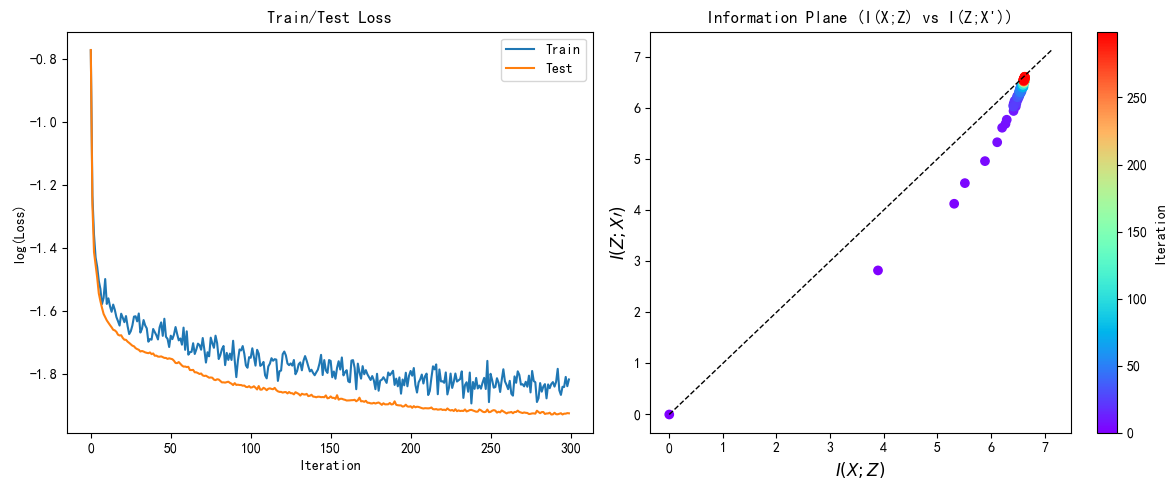

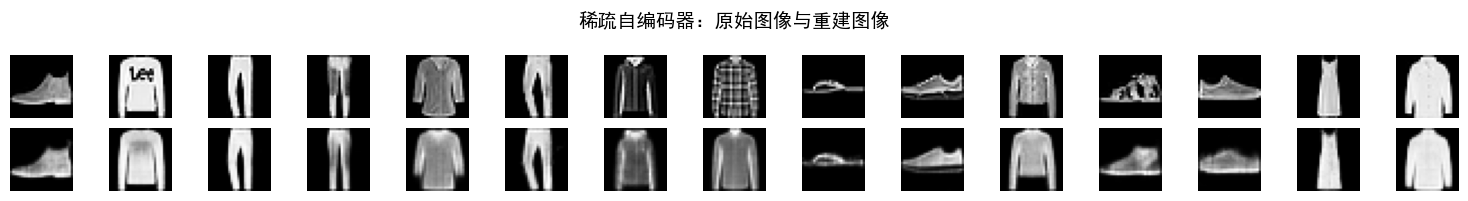

In [21]:
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # 编码器 5 层
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)   # 瓶颈层维度 = 16

        # 解码器 5 层
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        """
        x: 形状 (batch, 784)
        activations: 用来按层保存输出（numpy array），便于后面计算互信息
        返回：
          output: 最后重建出来的 (batch, 784)
          activations: 每层激活值的列表，长度 = 10 (前5 是编码器各层, 后5 是解码器各层)
        """
        if activations is None:
            activations = []

        # 编码器前向传播
        x = F.leaky_relu(self.enc1(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[0]

        x = F.leaky_relu(self.enc2(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[1]

        x = F.leaky_relu(self.enc3(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[2]

        x = F.leaky_relu(self.enc4(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[3]

        x = F.leaky_relu(self.enc5(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[4] ← 瓶颈层 Z

        # 解码器前向传播
        x = F.leaky_relu(self.dec1(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[5]

        x = F.leaky_relu(self.dec2(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[6]

        x = F.leaky_relu(self.dec3(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[7]

        x = F.leaky_relu(self.dec4(x), negative_slope=0.01)
        activations.append(x.detach().cpu().numpy())  # activations[8]

        x = torch.sigmoid(self.dec5(x))
        activations.append(x.detach().cpu().numpy())  # activations[9] ← 重建输出 X'

        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


# =========================
# 互信息估计：基于矩阵 Rényi 熵
# =========================
# def entropy_matrix_renyi(X, gamma, alpha):
#     """
#     计算 Renyi α-熵： 输入 X 的 shape=(N, d)
#     返回 A 矩阵（kernel/trace normalization）和 S = Renyi α-熵
#     """
#     N = X.shape[0]
#     d = X.shape[1]
#     sigma = gamma * N**(-1/(4 + d))
#     pairwise_dist = squareform(pdist(X, 'euclidean'))
#     K = np.exp(-pairwise_dist**2 / (2 * sigma**2))
#     # A = K / N
#     A = K / np.trace(K)
# 
#     _, eigenv, _ = np.linalg.svd(A)
#     S = (1.0 / (1 - alpha)) * np.log2(np.sum(eigenv**alpha) + epsilon).real
#     return A, S
import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('MI_XZ_array.npy', I_XZ_arr)
    np.save('MI_ZXprime_array.npy', I_ZXprime_arr)
    np.save('train_loss.npy', train_E_cont)
    np.save('test_loss.npy', test_E_cont)

    # ========== 可视化 ==========
    fig = plt.figure(figsize=(12, 5))

    # (1) 绘制 Train/Test Loss 曲线
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(np.log10(train_E_cont), label='Train')
    plt.plot(np.log10(test_E_cont),  label='Test')
    plt.title('Train/Test Loss')
    plt.xlabel(time_int)
    plt.ylabel('log(Loss)')
    plt.legend()

    # (2) 绘制 Information Plane: (I(X;Z) vs I(Z;X'))
    ax2 = plt.subplot(1, 2, 2)
    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)   # 对角线 y=x
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, ax=ax2, label=time_int)
    plt.title('Information Plane (I(X;Z) vs I(Z;X\'))')
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.show()


# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'sparse_ae_model.pth')
    np.save('train_loss.npy', history_trainloss)
    np.save('test_loss.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.1725, Test Loss: 0.1686
Epoch [1/50], Step [100/600], Train Loss: 0.0613, Test Loss: 0.0593
Epoch [1/50], Step [200/600], Train Loss: 0.0455, Test Loss: 0.0433
Epoch [1/50], Step [300/600], Train Loss: 0.0427, Test Loss: 0.0382
Epoch [1/50], Step [400/600], Train Loss: 0.0380, Test Loss: 0.0354
Epoch [1/50], Step [500/600], Train Loss: 0.0362, Test Loss: 0.0329
Epoch [1/50] 完成, Train Loss: 0.0362, Test Loss: 0.0329
Epoch [2/50], Step [0/600], Train Loss: 0.0359, Test Loss: 0.0311
Epoch [2/50], Step [100/600], Train Loss: 0.0324, Test Loss: 0.0297
Epoch [2/50], Step [200/600], Train Loss: 0.0299, Test Loss: 0.0288
Epoch [2/50], Step [300/600], Train Loss: 0.0330, Test Loss: 0.0279
Epoch [2/50], Step [400/600], Train Loss: 0.0316, Test Loss: 0.0275
Epoch [2/50], Step [500/600], Train Loss: 0.0309, Test Loss: 0.0268
Epoch [2/50] 完成, Train Loss: 0.0309, Test Loss: 0.0268
Epoch [3/50], Step [0/600], Train Loss: 0.0310, Test Loss: 0.

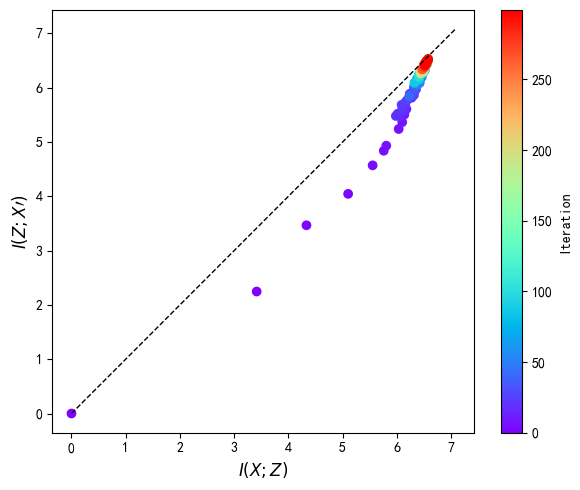

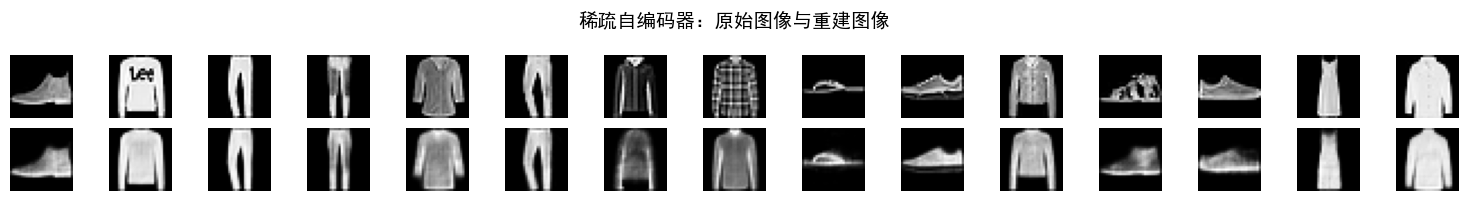

In [23]:
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        # 编码器 5 层
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)   # 瓶颈层维度 = 16

        # 解码器 5 层
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        """
        x: 形状 (batch, 784)
        activations: 用来按层保存输出（numpy array），便于后面计算互信息
        返回：
          output: 最后重建出来的 (batch, 784)
          activations: 每层激活值的列表，长度 = 10 (前5 是编码器各层, 后5 是解码器各层)
        """
        if activations is None:
            activations = []

        # 编码器前向传播
        x = F.relu(self.enc1(x) )
        activations.append(x.detach().cpu().numpy())  # activations[0]

        x = F.relu(self.enc2(x) )
        activations.append(x.detach().cpu().numpy())  # activations[1]

        x = F.relu(self.enc3(x))
        activations.append(x.detach().cpu().numpy())  # activations[2]

        x = F.relu(self.enc4(x) )
        activations.append(x.detach().cpu().numpy())  # activations[3]

        x = F.relu(self.enc5(x) )
        activations.append(x.detach().cpu().numpy())  # activations[4] ← 瓶颈层 Z

        # 解码器前向传播
        x = F.relu(self.dec1(x) )
        activations.append(x.detach().cpu().numpy())  # activations[5]

        x = F.relu(self.dec2(x) )
        activations.append(x.detach().cpu().numpy())  # activations[6]

        x = F.relu(self.dec3(x) )
        activations.append(x.detach().cpu().numpy())  # activations[7]

        x = F.relu(self.dec4(x))
        activations.append(x.detach().cpu().numpy())  # activations[8]

        x = torch.sigmoid(self.dec5(x))
        activations.append(x.detach().cpu().numpy())  # activations[9] ← 重建输出 X'

        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


# =========================
# 互信息估计：基于矩阵 Rényi 熵
# =========================
# def entropy_matrix_renyi(X, gamma, alpha):
#     """
#     计算 Renyi α-熵： 输入 X 的 shape=(N, d)
#     返回 A 矩阵（kernel/trace normalization）和 S = Renyi α-熵
#     """
#     N = X.shape[0]
#     d = X.shape[1]
#     sigma = gamma * N**(-1/(4 + d))
#     pairwise_dist = squareform(pdist(X, 'euclidean'))
#     K = np.exp(-pairwise_dist**2 / (2 * sigma**2))
#     # A = K / N
#     A = K / np.trace(K)
# 
#     _, eigenv, _ = np.linalg.svd(A)
#     S = (1.0 / (1 - alpha)) * np.log2(np.sum(eigenv**alpha) + epsilon).real
#     return A, S
import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('D:/深度学习与信息论/MI_XZ_array.npy', I_XZ_arr)
    np.save('D:/深度学习与信息论/MI_ZXprime_array.npy', I_ZXprime_arr)
    

    fig = plt.figure(figsize=(6, 5))

    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, label=time_int)
    
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.savefig('D:/深度学习与信息论/information_plane.eps', dpi=800)
    # plt.show() 可选添加，如果你也想展示在屏幕上



# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'D:/深度学习与信息论/sparse_autoencoder.pth')
    np.save('D:/深度学习与信息论/train_loss.npy', history_trainloss)
    np.save('D:/深度学习与信息论/test_loss.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.2011, Test Loss: 0.2036
Epoch [1/50], Step [100/600], Train Loss: 0.0548, Test Loss: 0.0522
Epoch [1/50], Step [200/600], Train Loss: 0.0417, Test Loss: 0.0378
Epoch [1/50], Step [300/600], Train Loss: 0.0367, Test Loss: 0.0354
Epoch [1/50], Step [400/600], Train Loss: 0.0351, Test Loss: 0.0342
Epoch [1/50], Step [500/600], Train Loss: 0.0332, Test Loss: 0.0308
Epoch [1/50] 完成, Train Loss: 0.0332, Test Loss: 0.0308
Epoch [2/50], Step [0/600], Train Loss: 0.0315, Test Loss: 0.0281
Epoch [2/50], Step [100/600], Train Loss: 0.0297, Test Loss: 0.0268
Epoch [2/50], Step [200/600], Train Loss: 0.0279, Test Loss: 0.0257
Epoch [2/50], Step [300/600], Train Loss: 0.0256, Test Loss: 0.0243
Epoch [2/50], Step [400/600], Train Loss: 0.0258, Test Loss: 0.0235
Epoch [2/50], Step [500/600], Train Loss: 0.0250, Test Loss: 0.0236
Epoch [2/50] 完成, Train Loss: 0.0250, Test Loss: 0.0236
Epoch [3/50], Step [0/600], Train Loss: 0.0254, Test Loss: 0.

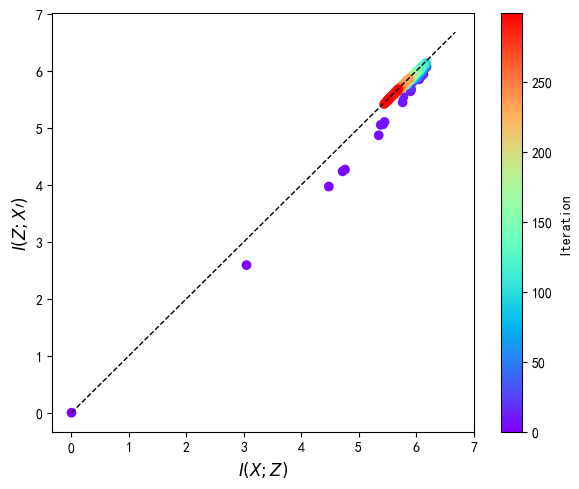

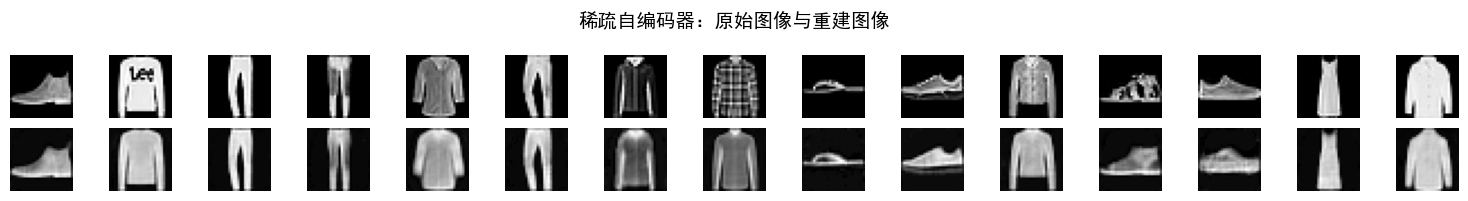

In [24]:
import math
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
##GeLU
class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.3))

    def forward(self, input):
        temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        # temp = input*torch.sigmoid(input/self.sigma)#SiLU
        return temp

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.act = CustomActivation()

        # encoder
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        # decoder
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        if activations is None:
            activations = []
        # encoding
        x = self.act(self.enc1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc5(x))
        activations.append(x.detach().cpu().numpy())
       
        # decoding
        x = self.act(self.dec1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec5(x))
        activations.append(x.detach().cpu().numpy())
        
        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('D:/深度学习与信息论/MI_XZ_arrayG.npy', I_XZ_arr)
    np.save('D:/深度学习与信息论/MI_ZX_arrayG.npy', I_ZXprime_arr)
    

    fig = plt.figure(figsize=(6, 5))

    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, label=time_int)
    
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.savefig('D:/深度学习与信息论/information_planeG.eps', dpi=800)
    # plt.show() 可选添加，如果你也想展示在屏幕上



# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'D:/深度学习与信息论/sparse_autoencoderG.pth')
    np.save('D:/深度学习与信息论/train_lossG.npy', history_trainloss)
    np.save('D:/深度学习与信息论/test_lossG.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.2077, Test Loss: 0.2043
Epoch [1/50], Step [100/600], Train Loss: 0.0650, Test Loss: 0.0616
Epoch [1/50], Step [200/600], Train Loss: 0.0439, Test Loss: 0.0388
Epoch [1/50], Step [300/600], Train Loss: 0.0372, Test Loss: 0.0355
Epoch [1/50], Step [400/600], Train Loss: 0.0372, Test Loss: 0.0349
Epoch [1/50], Step [500/600], Train Loss: 0.0371, Test Loss: 0.0327
Epoch [1/50] 完成, Train Loss: 0.0371, Test Loss: 0.0327
Epoch [2/50], Step [0/600], Train Loss: 0.0364, Test Loss: 0.0318
Epoch [2/50], Step [100/600], Train Loss: 0.0317, Test Loss: 0.0292
Epoch [2/50], Step [200/600], Train Loss: 0.0291, Test Loss: 0.0272
Epoch [2/50], Step [300/600], Train Loss: 0.0289, Test Loss: 0.0262
Epoch [2/50], Step [400/600], Train Loss: 0.0286, Test Loss: 0.0258
Epoch [2/50], Step [500/600], Train Loss: 0.0277, Test Loss: 0.0250
Epoch [2/50] 完成, Train Loss: 0.0277, Test Loss: 0.0250
Epoch [3/50], Step [0/600], Train Loss: 0.0270, Test Loss: 0.

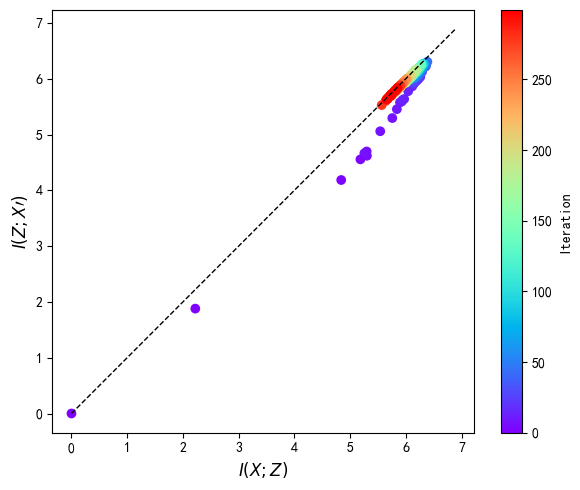

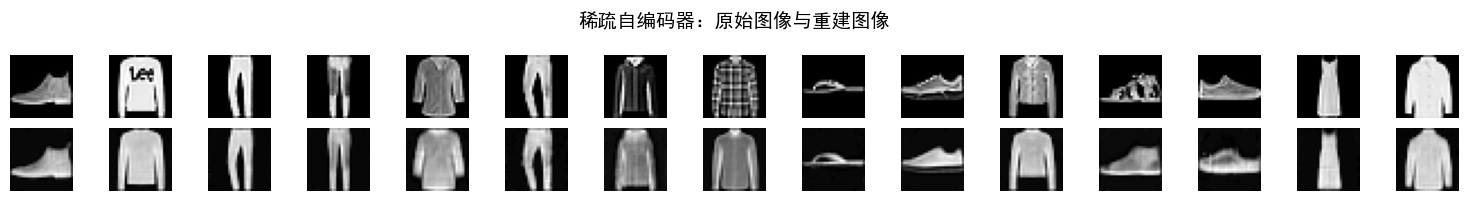

In [25]:
import math
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
##SiLU
class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.3))

    def forward(self, input):
        # temp = input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))#GELU
        temp = input*torch.sigmoid(input/self.sigma)#SiLU
        return temp

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.act = CustomActivation()

        # encoder
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        # decoder
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        if activations is None:
            activations = []
        # encoding
        x = self.act(self.enc1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc5(x))
        activations.append(x.detach().cpu().numpy())
       
        # decoding
        x = self.act(self.dec1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec5(x))
        activations.append(x.detach().cpu().numpy())
        
        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('D:/深度学习与信息论/MI_XZ_arrayS.npy', I_XZ_arr)
    np.save('D:/深度学习与信息论/MI_ZX_arrayS.npy', I_ZXprime_arr)
    

    fig = plt.figure(figsize=(6, 5))

    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, label=time_int)
    
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.savefig('D:/深度学习与信息论/information_planeS.eps', dpi=800)
    # plt.show() 可选添加，如果你也想展示在屏幕上



# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'D:/深度学习与信息论/sparse_autoencoderS.pth')
    np.save('D:/深度学习与信息论/train_lossS.npy', history_trainloss)
    np.save('D:/深度学习与信息论/test_lossS.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.2151, Test Loss: 0.2033
Epoch [1/50], Step [100/600], Train Loss: 0.0655, Test Loss: 0.0629
Epoch [1/50], Step [200/600], Train Loss: 0.0623, Test Loss: 0.0581
Epoch [1/50], Step [300/600], Train Loss: 0.0471, Test Loss: 0.0425
Epoch [1/50], Step [400/600], Train Loss: 0.0420, Test Loss: 0.0393
Epoch [1/50], Step [500/600], Train Loss: 0.0396, Test Loss: 0.0357
Epoch [1/50] 完成, Train Loss: 0.0396, Test Loss: 0.0357
Epoch [2/50], Step [0/600], Train Loss: 0.0395, Test Loss: 0.0342
Epoch [2/50], Step [100/600], Train Loss: 0.0369, Test Loss: 0.0308
Epoch [2/50], Step [200/600], Train Loss: 0.0350, Test Loss: 0.0284
Epoch [2/50], Step [300/600], Train Loss: 0.0325, Test Loss: 0.0271
Epoch [2/50], Step [400/600], Train Loss: 0.0314, Test Loss: 0.0263
Epoch [2/50], Step [500/600], Train Loss: 0.0339, Test Loss: 0.0258
Epoch [2/50] 完成, Train Loss: 0.0339, Test Loss: 0.0258
Epoch [3/50], Step [0/600], Train Loss: 0.0324, Test Loss: 0.

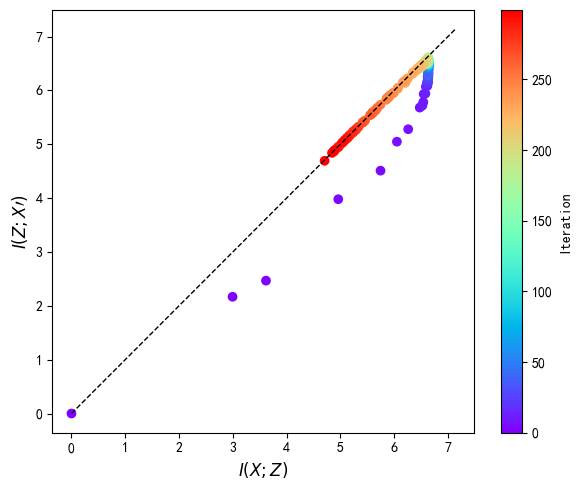

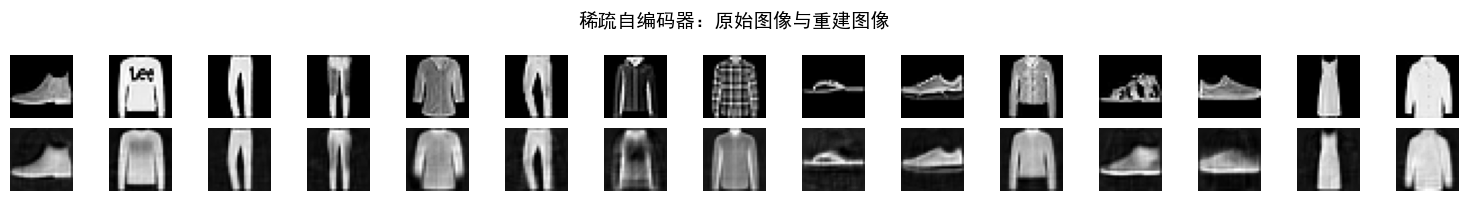

In [28]:
import math
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
##Mish
class CustomActivation(nn.Module):
    def __init__(self):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(10.5))  # 可训练的 sigma 参数

    def forward(self, input):
        return input * torch.tanh(torch.log1p(torch.exp(input / self.sigma)))
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.act = CustomActivation()

        # encoder
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        # decoder
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        if activations is None:
            activations = []
        # encoding
        x = self.act(self.enc1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc5(x))
        activations.append(x.detach().cpu().numpy())
       
        # decoding
        x = self.act(self.dec1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec5(x))
        activations.append(x.detach().cpu().numpy())
        
        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('D:/深度学习与信息论/MI_XZ_arrayM.npy', I_XZ_arr)
    np.save('D:/深度学习与信息论/MI_ZX_arrayM.npy', I_ZXprime_arr)
    

    fig = plt.figure(figsize=(6, 5))

    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, label=time_int)
    
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.savefig('D:/深度学习与信息论/information_planeM.eps', dpi=800)
    # plt.show() 可选添加，如果你也想展示在屏幕上



# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'D:/深度学习与信息论/sparse_autoencoderM.pth')
    np.save('D:/深度学习与信息论/train_lossM.npy', history_trainloss)
    np.save('D:/深度学习与信息论/test_lossM.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


使用设备: cuda
训练开始!
Epoch [1/50], Step [0/600], Train Loss: 0.1919, Test Loss: 0.1943
Epoch [1/50], Step [100/600], Train Loss: 0.0400, Test Loss: 0.0416
Epoch [1/50], Step [200/600], Train Loss: 0.0361, Test Loss: 0.0332
Epoch [1/50], Step [300/600], Train Loss: 0.0278, Test Loss: 0.0275
Epoch [1/50], Step [400/600], Train Loss: 0.0274, Test Loss: 0.0262
Epoch [1/50], Step [500/600], Train Loss: 0.0262, Test Loss: 0.0250
Epoch [1/50] 完成, Train Loss: 0.0262, Test Loss: 0.0250
Epoch [2/50], Step [0/600], Train Loss: 0.0251, Test Loss: 0.0244
Epoch [2/50], Step [100/600], Train Loss: 0.0229, Test Loss: 0.0235
Epoch [2/50], Step [200/600], Train Loss: 0.0251, Test Loss: 0.0228
Epoch [2/50], Step [300/600], Train Loss: 0.0240, Test Loss: 0.0219
Epoch [2/50], Step [400/600], Train Loss: 0.0234, Test Loss: 0.0211
Epoch [2/50], Step [500/600], Train Loss: 0.0227, Test Loss: 0.0205
Epoch [2/50] 完成, Train Loss: 0.0227, Test Loss: 0.0205
Epoch [3/50], Step [0/600], Train Loss: 0.0226, Test Loss: 0.

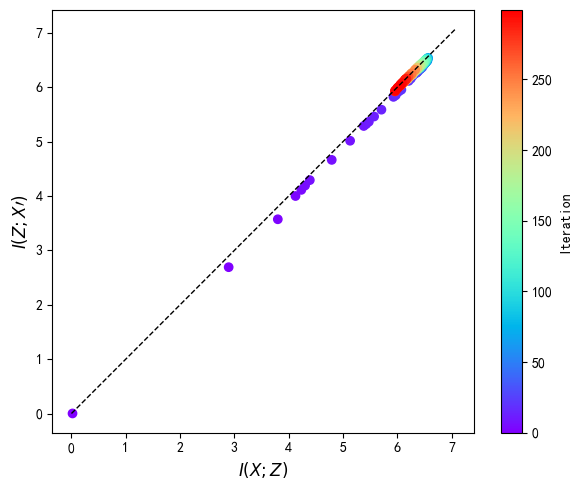

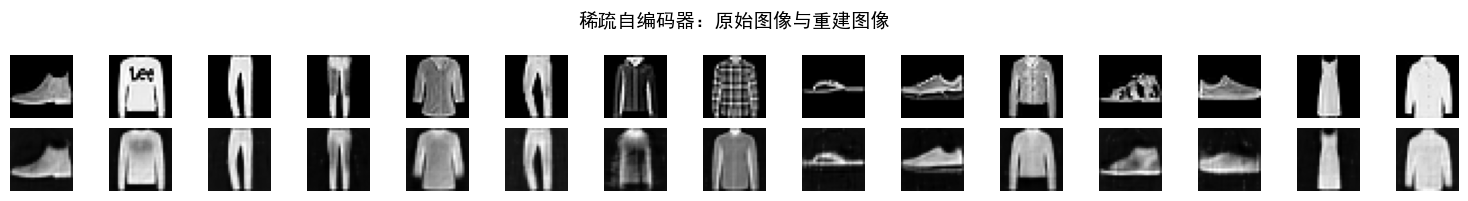

In [27]:
import math
import numpy as np
import copy
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
import matplotlib.pyplot as plt
import pickle

# =========================
# 训练参数设置
# =========================
EPOCH = 50
batch = 100
lr = 0.001
reg_param = 0.001         # 稀疏正则权重
view = 15                 # 最后可视化多少张重建图
gamma = 2
alpha = 1.01
time_int = 'Iteration'
epsilon = 1e-8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"使用设备: {DEVICE}")

# =========================
# 数据加载
# =========================
trainset = datasets.FashionMNIST(root='./.data/', train=True, download=True, transform=transforms.ToTensor())
testset  = datasets.FashionMNIST(root='./.data/', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
test_loader  = torch.utils.data.DataLoader(testset,  batch_size=batch, shuffle=True)

# =========================
# 网络定义（五层编码 + 五层解码）
# =========================
#ELU
class CustomActivation(nn.Module):
    def __init__(self, alpha=1.0):
        super(CustomActivation, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(0.90))  # 可学习参数 sigma
        self.alpha = alpha  # ELU 的 alpha 参数

    def forward(self, input):
        return torch.where(input >= 0, input, self.alpha * (torch.exp(input / self.sigma) - 1))

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()

        self.act = CustomActivation()

        # encoder
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 128)
        self.enc3 = nn.Linear(128, 64)
        self.enc4 = nn.Linear(64, 32)
        self.enc5 = nn.Linear(32, 16)

        # decoder
        self.dec1 = nn.Linear(16, 32)
        self.dec2 = nn.Linear(32, 64)
        self.dec3 = nn.Linear(64, 128)
        self.dec4 = nn.Linear(128, 256)
        self.dec5 = nn.Linear(256, 784)

    def forward(self, x, activations=None):
        if activations is None:
            activations = []
        # encoding
        x = self.act(self.enc1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.enc5(x))
        activations.append(x.detach().cpu().numpy())
       
        # decoding
        x = self.act(self.dec1(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec2(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec3(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec4(x))
        activations.append(x.detach().cpu().numpy())
        x = self.act(self.dec5(x))
        activations.append(x.detach().cpu().numpy())
        
        return x, activations

# 实例化模型
sae = SparseAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
criterion = nn.MSELoss()

# =========================
# 稀疏正则损失：取编码器前 5 层的 L1 平均
# =========================
def sparse_loss(activations):
    # activations[:5] 是编码器五层的输出，每层 shape=(batch, layer_dim)
    loss = 0.0
    for layer_act in activations[:5]:
        # 这里把 numpy array 再包成 tensor，仅为了统一放到 DEVICE 上求均值
        t = torch.tensor(layer_act, device=DEVICE)
        loss += torch.mean(torch.abs(t))
    return loss / 5

# =========================
# 训练函数：每 100 步记录一次 activations/history
# =========================
def train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch):
    sae.train()
    for step, (x, _) in enumerate(train_loader):
        x = x.view(-1, 784).to(DEVICE)
        activations = []
        output, activations = sae(x, activations)

        # 重构误差 + 稀疏正则
        mse_loss = criterion(output, x)
        l1_loss = sparse_loss(activations)
        total_loss = mse_loss + reg_param * l1_loss

        optimizer.zero_grad()
        total_loss.backward()
        # 梯度裁剪（可选）
        torch.nn.utils.clip_grad_norm_(sae.parameters(), 1.0)
        optimizer.step()

        # 每 100 步记录一次 activation 和 train/test loss
        if step % 100 == 0:
            # 计算在整个测试集上的重构误差（为了记录 test_loss）
            test_data = testset.data.view(-1, 784).float() / 255.
            test_data = test_data.to(DEVICE)
            with torch.no_grad():
                test_output, _ = sae(test_data)
                test_loss = criterion(test_output, test_data).item()

            # 保存这一步的“所有层激活”及 train_loss/test_loss
            history_activations.append(copy.deepcopy(activations))
            history_trainloss.append(total_loss.item())
            history_testloss.append(test_loss)
            print(f"Epoch [{epoch}/{EPOCH}], Step [{step}/{len(train_loader)}], "
                  f"Train Loss: {total_loss.item():.4f}, Test Loss: {test_loss:.4f}")
    return history_activations, history_trainloss, history_testloss


import numpy as np
from scipy.spatial.distance import pdist, squareform



epsilon = 1e-8

def entropy_matrix_renyi(X, gamma=1.0, alpha=1.01, use_N_scaling=False):
    N, d = X.shape
    if use_N_scaling:
        sigma = gamma * (N ** (-1.0 / (4 + d)))
    else:
        sigma = gamma

    pairwise_dist = squareform(pdist(X, 'euclidean'))
    K = np.exp(- pairwise_dist**2 / (2 * sigma**2))

    trace_K = np.trace(K)
    if trace_K < 1e-12:
        trace_K = 1e-12
    A = K / trace_K

    _, eigvals, _ = np.linalg.svd(A, full_matrices=False)
    eigvals = np.clip(eigvals, a_min=0, a_max=None)

    S = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals**alpha) + epsilon).real
    return A, S

def MI(X, Y, gamma=1.0, alpha=1.01, use_N_scaling=False):
    A_X, S_X = entropy_matrix_renyi(X, gamma, alpha, use_N_scaling)
    A_Y, S_Y = entropy_matrix_renyi(Y, gamma, alpha, use_N_scaling)

    A_XY_raw = A_X * A_Y
    trace_raw = np.trace(A_XY_raw)
    if trace_raw < 1e-12:
        trace_raw = 1e-12
    A_XY = A_XY_raw / trace_raw

    _, eigvals_XY, _ = np.linalg.svd(A_XY, full_matrices=False)
    eigvals_XY = np.clip(eigvals_XY, a_min=0, a_max=None)
    S_XY = (1.0 / (1.0 - alpha)) * np.log2(np.sum(eigvals_XY**alpha) + epsilon).real

    I_XY = S_X + S_Y - S_XY
    return I_XY, S_XY


# =========================
# IP 函数：真正绘制 (I(X;Z), I(Z;X'))
# =========================
def IP(history_activations, history_trainloss, history_testloss):
    """
    history_activations[j] 是一个列表，包含当 step=j 时
    每层的激活值（numpy array）：
      activations[0..4] = 编码器层 1..5 输出，
      activations[4] = 瓶颈层 Z (shape=(batch, 16))
      activations[5..9] = 解码器层 1..5 输出，
      activations[9] = 最后重建 X' (shape=(batch, 784))

    绘图时，用：
      I(X; Z)       → MI(X, Z)
      I(Z; X')      → MI(Z, X')
    """
    step = len(history_trainloss)
    I_XZ_arr = np.zeros(step)
    I_ZXprime_arr = np.zeros(step)
    train_E_cont = np.array(history_trainloss)
    test_E_cont  = np.array(history_testloss)

    # 先把整个测试集取出来，只用前 batch 个样本计算互信息
    FMNIST_test = testset.data.view(-1, 784).float().numpy() / 255.
    X_test_batches = FMNIST_test[:batch, :]  # shape = (batch, 784)

    for j in range(step):
        activations = history_activations[j]
        # 编码器第 5 层的输出 = 瓶颈层 Z
        Z = activations[4]       # shape=(batch, 16)
        # 解码器最后一层的重建输出 = X'
        Xp = activations[9]      # shape=(batch, 784)

        # 计算 I(X; Z)
        I_xz, _ = MI(X_test_batches, Z, gamma, alpha)
        # 计算 I(Z; X')
        I_zx, _ = MI(Z, Xp, gamma, alpha)

        I_XZ_arr[j] = I_xz
        I_ZXprime_arr[j] = I_zx

    # 保存结果到本地（可选）
    np.save('D:/深度学习与信息论/MI_XZ_arrayE.npy', I_XZ_arr)
    np.save('D:/深度学习与信息论/MI_ZX_arrayE.npy', I_ZXprime_arr)
    

    fig = plt.figure(figsize=(6, 5))

    xx = np.linspace(0, max(I_XZ_arr.max(), I_ZXprime_arr.max()) + 0.5, 200)
    plt.plot(xx, xx, 'k--', linewidth=1)
    im = plt.scatter(I_XZ_arr, I_ZXprime_arr, c=np.arange(step), cmap='rainbow')
    plt.colorbar(im, label=time_int)
    
    plt.xlabel(r'$I(X;Z)$', fontsize=12)
    plt.ylabel(r'$I(Z;X\prime)$', fontsize=12)
    plt.tight_layout()
    plt.savefig('D:/深度学习与信息论/information_planeE.eps', dpi=800)
    # plt.show() 可选添加，如果你也想展示在屏幕上



# =========================
# 主函数：训练 + 绘制信息平面 + 重建图像可视化
# =========================
def main():
    history_activations = []
    history_trainloss   = []
    history_testloss    = []

    print('训练开始!')
    for epoch in range(1, EPOCH + 1):
        history_activations, history_trainloss, history_testloss = \
            train(sae, train_loader, history_activations, history_trainloss, history_testloss, epoch)
        print(f"Epoch [{epoch}/{EPOCH}] 完成, "
              f"Train Loss: {history_trainloss[-1]:.4f}, "
              f"Test Loss: {history_testloss[-1]:.4f}")

    # 训练结束后保存模型及 Loss
    torch.save(sae.state_dict(), 'D:/深度学习与信息论/sparse_autoencoderE.pth')
    np.save('D:/深度学习与信息论/train_lossE.npy', history_trainloss)
    np.save('D:/深度学习与信息论/test_lossE.npy', history_testloss)

    print('训练结束!\n开始计算互信息...')
    IP(history_activations, history_trainloss, history_testloss)

    # =========================
    # 重建图像可视化
    # =========================
    sae.eval()
    with torch.no_grad():
        sample_inputs = testset.data[:view].view(-1, 784).float() / 255.
        sample_inputs = sample_inputs.to(DEVICE)
        reconstructed, _ = sae(sample_inputs)  # 直接前向得到重建结果

    sample_inputs_np   = sample_inputs.view(-1, 1, 28, 28).cpu().numpy()
    reconstructed_np   = reconstructed.view(-1, 1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, view, figsize=(view, 2))
    for i in range(view):
        axes[0, i].imshow(sample_inputs_np[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_np[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('原图', fontsize=12)
    axes[1, 0].set_ylabel('重建', fontsize=12)
    plt.suptitle("稀疏自编码器：原始图像与重建图像", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


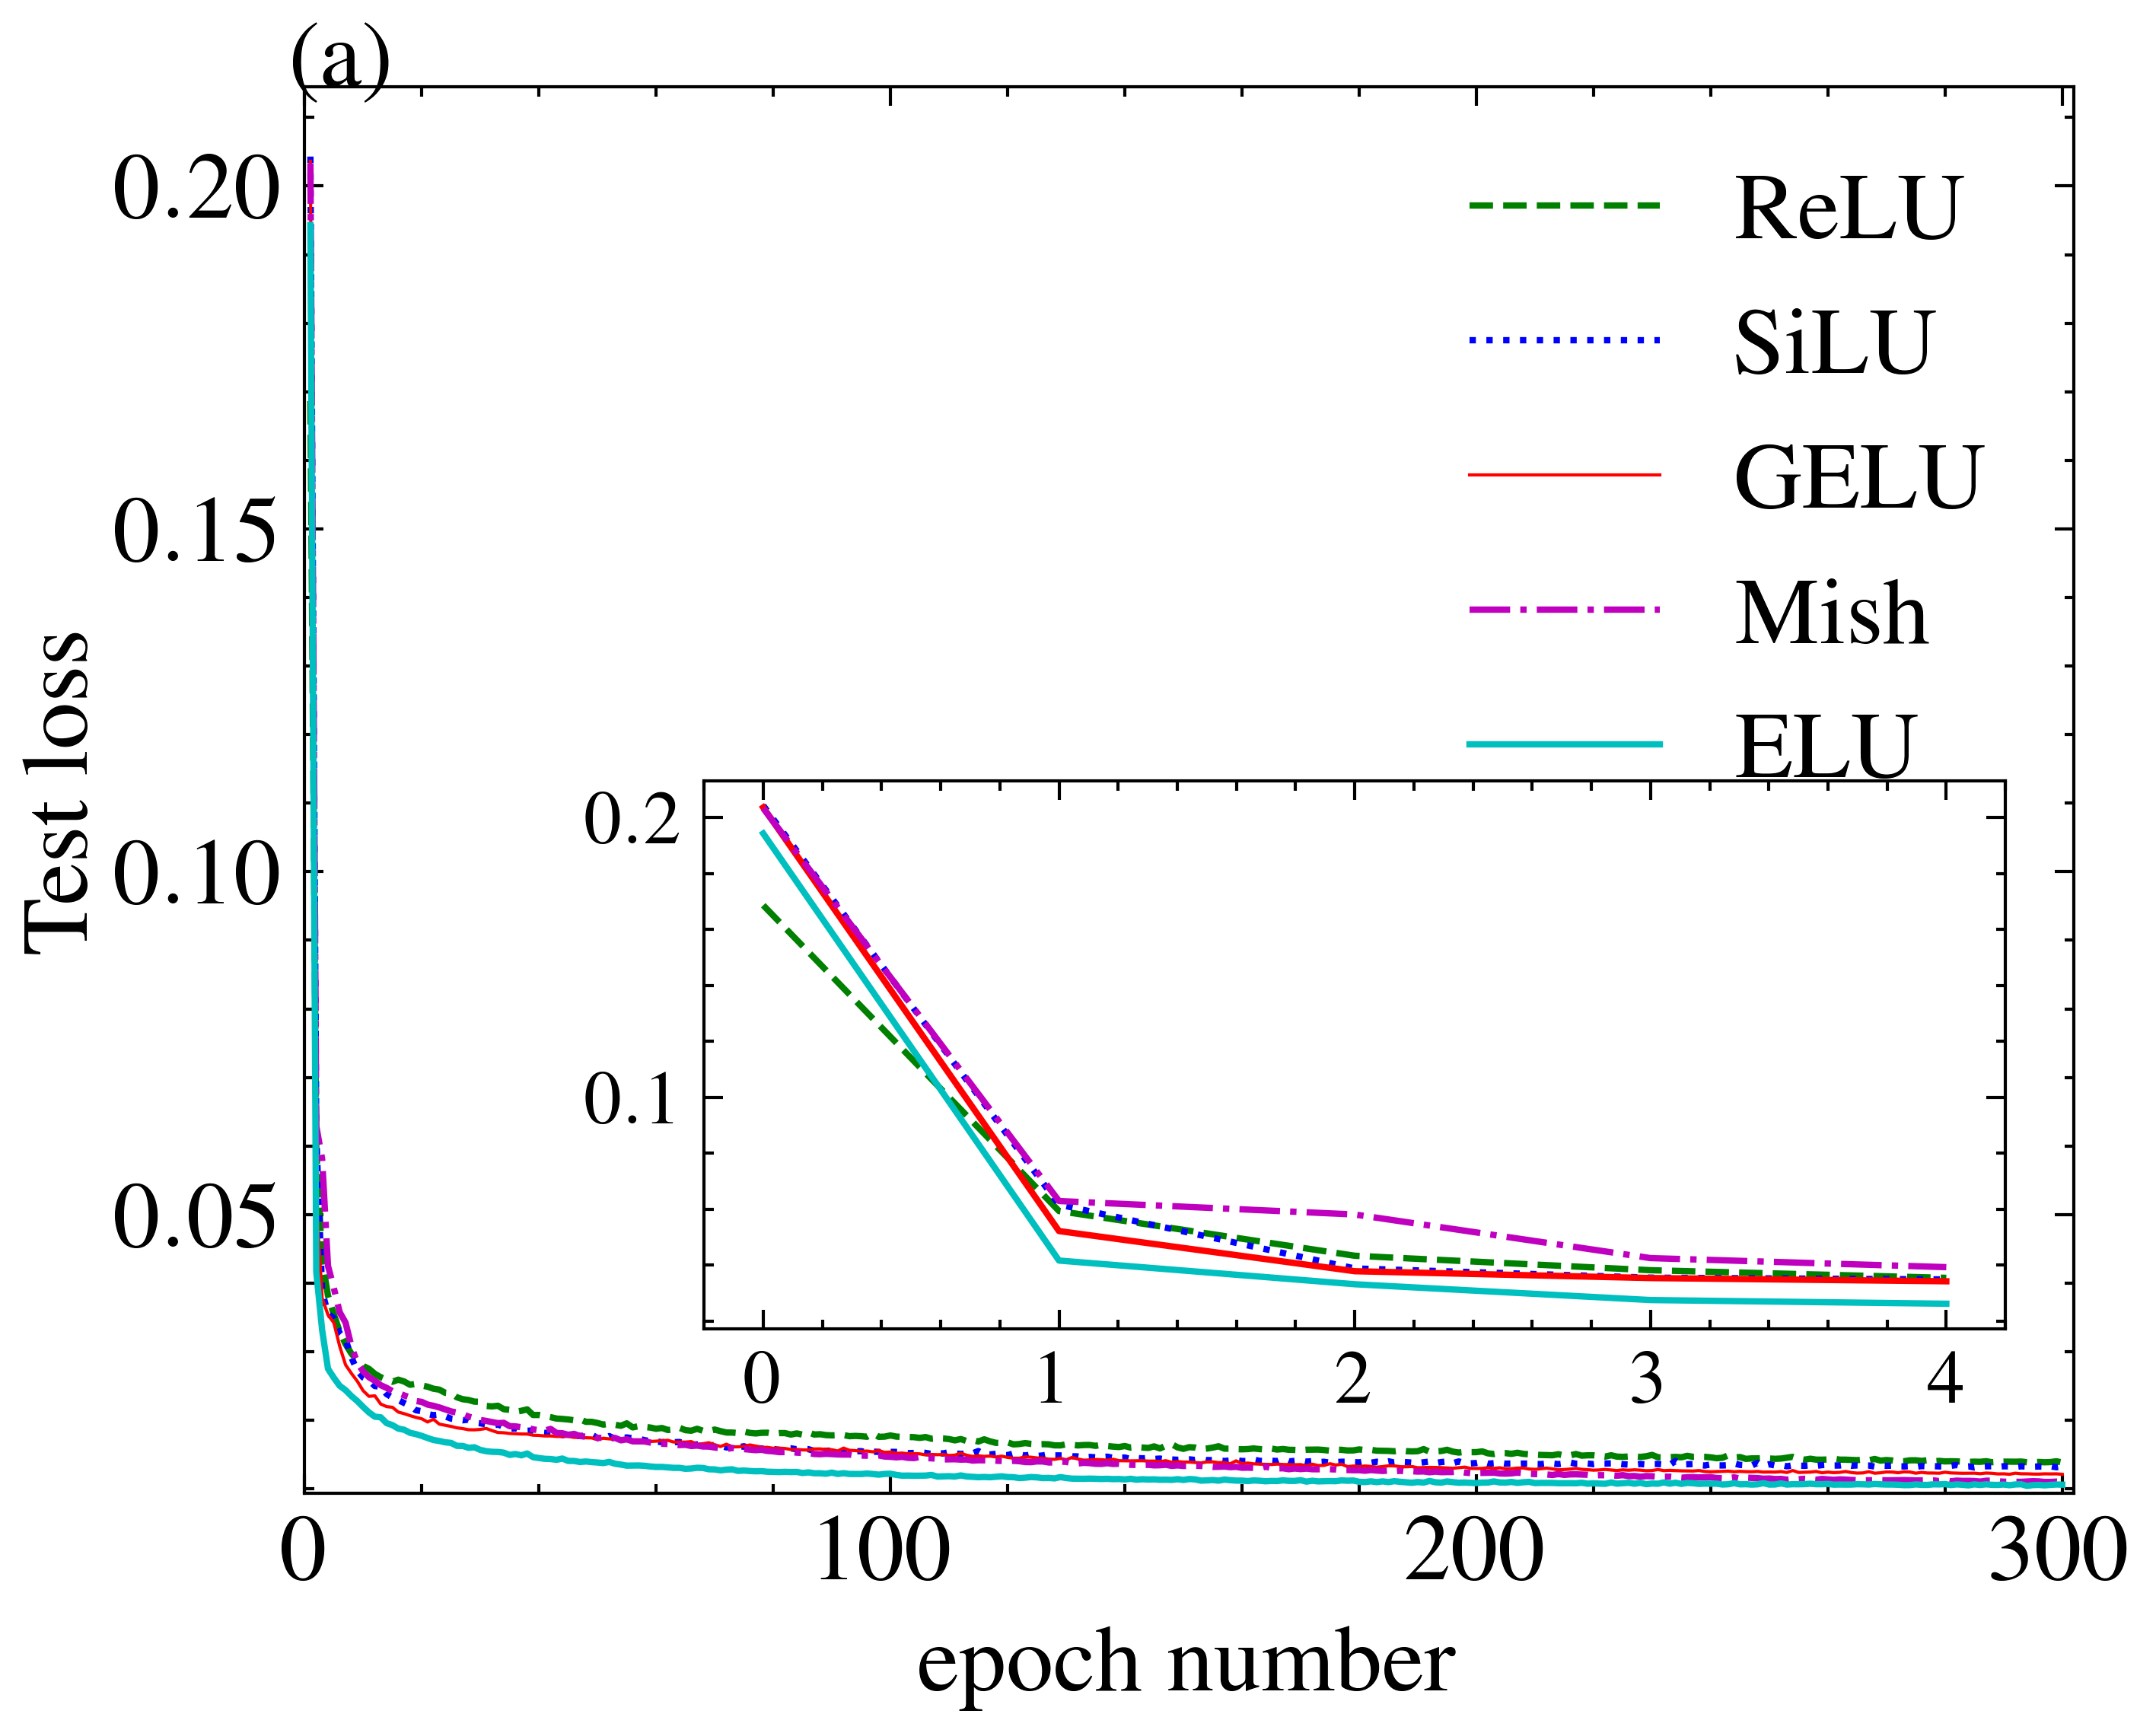

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# 加载loss数据（假设路径和变量名与accuracy类似）
lossR = np.load('D:/深度学习与信息论/test_loss.npy', allow_pickle=True)
lossG = np.load('D:/深度学习与信息论/test_lossG.npy', allow_pickle=True)
lossS = np.load('D:/深度学习与信息论/test_lossS.npy', allow_pickle=True)
lossM = np.load('D:/深度学习与信息论/test_lossM.npy', allow_pickle=True)
lossE = np.load('D:/深度学习与信息论/test_lossE.npy', allow_pickle=True)

# 设置字体和样式
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'
plt.style.use(['science', 'ieee'])

# 创建图像与坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('epoch number', fontsize=15)
ax.set_ylabel(r"Test loss", fontsize=15, labelpad=1)
ax.set_xlim(0, len(lossR) + 2)

# 自动设置y轴范围
min_loss = min(np.min(lossR), np.min(lossG), np.min(lossS), np.min(lossM), np.min(lossE))
max_loss = max(np.max(lossR), np.max(lossG), np.max(lossS), np.max(lossM), np.max(lossE))
ax.set_ylim(min_loss * 0.9, max_loss * 1.05)

# 创建 epoch 数组
epochs = np.arange(1, len(lossR) + 1)

# 绘制loss曲线
ax.plot(epochs, lossR, 'g--', lw=1, label=r"ReLU")
ax.plot(epochs, lossS, 'b:', lw=1, label=r"SiLU")
ax.plot(epochs, lossG, 'r-', lw=0.5, label=r"GELU")
ax.plot(epochs, lossM, 'm-.', lw=1, label=r"Mish")
ax.plot(epochs, lossE, 'c-', lw=1, label=r"ELU")
ax.text(-2.1, max_loss * 1.05, '(a)', fontdict={'size': 15, 'color': 'black'})
ax.legend(loc='upper right', fontsize=15)
# 
# # 添加放大子图
left, bottom, width, height = [0.3, 0.2, 0.57, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

step = np.arange(0, 101)
# ax2.plot(step[0:5], lossR[0:5], 'g--', marker='*', label=r"ReLU")
# ax2.plot(step[0:5], lossS[0:5], 'b:', marker='o', label=r"SiLU")
# ax2.plot(step[0:5], lossG[0:5], 'r-', marker='^', label=r"GELU")
# ax2.plot(step[0:5], lossM[0:5], 'm-.', marker='s', label=r"Mish")
# ax2.plot(step[0:5], lossE[0:5], 'c-', marker='d', label=r"ELU")
ax2.plot(step[0:5], lossR[0:5], 'g--', label=r"ReLU")
ax2.plot(step[0:5], lossS[0:5], 'b:',  label=r"SiLU")
ax2.plot(step[0:5], lossG[0:5], 'r-', label=r"GELU")
ax2.plot(step[0:5], lossM[0:5], 'm-.', label=r"Mish")
ax2.plot(step[0:5], lossE[0:5], 'c-',  label=r"ELU")

ax2.tick_params(labelsize=12)
# ax2.legend(loc='upper right', fontsize=12)

plt.show()
fig.savefig('D:/深度学习与信息论/Figsaeloss.eps', dpi=800)
